# Part of Speech (POS) Tagging

* **Part of Speech** is essential to provide the syntactic behavior of the 
words in a sentence. It indicates how the word functions in meaning as well as grammatically within the sentence. 
* In **Natural Language Processing**, PoS form as applications for Named Entity Recognition(NER), Sentiment Analysis, Information Retreival etc.
* Probabilistic models like HMM, MEMM use PoS tags to generate sentence that has well defined Syntatic and Semantic relationship.

In [1]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 77 kB 2.9 MB/s 


In [2]:
from pyunpack import Archive
Archive('/content/drive/My Drive/LSTM/glove.6B.100d.rar').extractall('/content')

In [3]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 743 kB 5.0 MB/s 


In [158]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
import re
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# CRF(Conditional Random Field)

* Linear chain CRF is the special case of **Markov Random Field**, where input random variables are conditioned(i.e. fixed).

* It is the family of **undirected graph models**.

* It is the **Discriminative model**, where model is nothing but the **Conditional Probability**. 
$$p(y\mid x)$$

In [5]:
nltk.download('treebank')
nltk.download('universal_tagset')
nltk.download('brown')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [6]:
brown_corpus = nltk.corpus.brown.tagged_sents(tagset='universal')

In [7]:
brown_corpus[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [8]:
tagged_words = [tup for sent in brown_corpus for tup in sent]
print("Total Number of Tagged words", len(tagged_words))
vocab = set([word for word,tag in tagged_words])
print("Vocabulary of the Corpus",len(vocab))
tags = set([tag for word,tag in tagged_words])
print("Number of Tags in the Corpus ",len(tags))

Total Number of Tagged words 1161192
Vocabulary of the Corpus 56057
Number of Tags in the Corpus  12


In [9]:
train_set, test_set = train_test_split(brown_corpus, test_size=0.2, random_state=30)
print("Number of Sentences in Training Data ",len(train_set))
print("Number of Sentences in Testing Data ",len(test_set))

Number of Sentences in Training Data  45872
Number of Sentences in Testing Data  11468


In [10]:
def features(sentence,index):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence.
    return {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0  
         }

def prepareData(tagged_sentences):
    X,y=[],[]
    for sentences in tagged_sentences:
        X.append([features([word for word,tag in sentences], index) for index in range(len(sentences))])
        y.append([tag for word,tag in sentences])
    return X,y
X_train,y_train=prepareData(train_set)
X_test,y_test=prepareData(test_set)

In [11]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=150,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.01, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=150,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [12]:
y_pred=crf.predict(X_test)
print("F1 score on Test Data ")
print(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=crf.classes_))
print("F1 score on Training Data ")
y_pred_train=crf.predict(X_train)
print(metrics.flat_f1_score(y_train, y_pred_train, average='weighted', labels=crf.classes_))

### Classification report of Test Data.
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

F1 score on Test Data 
0.9782296015211704
F1 score on Training Data 
0.9919546311593458
              precision    recall  f1-score   support

         ADP      0.979     0.985     0.982     29227
         DET      0.994     0.995     0.995     27551
        NOUN      0.973     0.979     0.976     55666
        PRON      0.993     0.988     0.991      9837
        VERB      0.980     0.977     0.978     36748
         ADJ      0.941     0.938     0.939     16922
           .      1.000     1.000     1.000     29633
         PRT      0.945     0.946     0.946      5980
        CONJ      0.995     0.996     0.996      7725
         ADV      0.951     0.940     0.945     11282
         NUM      0.986     0.990     0.988      2904
           X      0.826     0.357     0.499       305

    accuracy                          0.978    233780
   macro avg      0.964     0.924     0.936    233780
weighted avg      0.978     0.978     0.978    233780



In [13]:
y_test[4]

['.', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NUM', '.']

In [14]:
crf.predict([X_test[4]])

[['.', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NUM', '.']]

In [15]:
crf.classes_

['ADP',
 'DET',
 'NOUN',
 'PRON',
 'VERB',
 'ADJ',
 '.',
 'PRT',
 'CONJ',
 'ADV',
 'NUM',
 'X']

In [16]:
df = pd.DataFrame(columns = crf.classes_, 
                   index = crf.classes_, dtype='float32')

In [17]:
for keys, value in crf.transition_features_.items():
  df.loc[keys[0], keys[1]] = value

In [18]:
df

,ADP,DET,NOUN,PRON,VERB,ADJ,.,PRT,CONJ,ADV,NUM,X
ADP,-0.436580,0.512122,2.810561,-0.226178,-0.660356,0.980434,-2.199761,-1.461639,-2.025863,-0.728139,-0.243839,-0.032220
DET,-3.647355,-3.740797,2.645119,-3.258694,0.447580,1.162723,-2.813060,-2.432468,-3.774316,-1.270468,-2.114691,-0.112860
NOUN,1.076790,-1.209699,3.487630,2.112266,2.626695,0.885558,0.871829,0.380946,0.626980,1.600076,0.305738,0.757410
PRON,-1.649891,-2.048625,-1.053691,-1.417530,2.479242,-1.801739,-1.795349,-1.738695,-1.614002,0.060274,-2.682574,-1.838180
VERB,1.315139,0.391589,3.723025,0.124310,1.098962,1.740181,-0.209493,1.752670,-0.206671,2.423649,0.506040,0.313958
ADJ,0.508311,-2.061978,5.289938,-1.162041,0.416540,1.617852,0.472311,0.151295,0.274127,0.717949,1.364694,1.821738
.,-1.080952,-1.440876,0.474039,-1.857808,0.166882,-0.372625,-0.986853,-0.622559,-0.191968,-0.574270,-2.540220,-0.481363
PRT,-0.135994,-0.685296,-0.244671,-2.029070,3.066626,-0.913137,0.154693,-0.248141,-2.170163,0.303141,-1.811571,-1.908916
CONJ,-0.996644,-1.091069,0.884645,-1.745131,-0.019059,0.463081,-4.525196,-1.322434,-3.093159,0.161118,-2.134609,-1.061590
ADV,0.393200,-0.503156,0.210088,-1.967342,1.396654,2.184743,-0.222237,-0.645774,-0.674010,1.779627,-0.151419,-1.411631


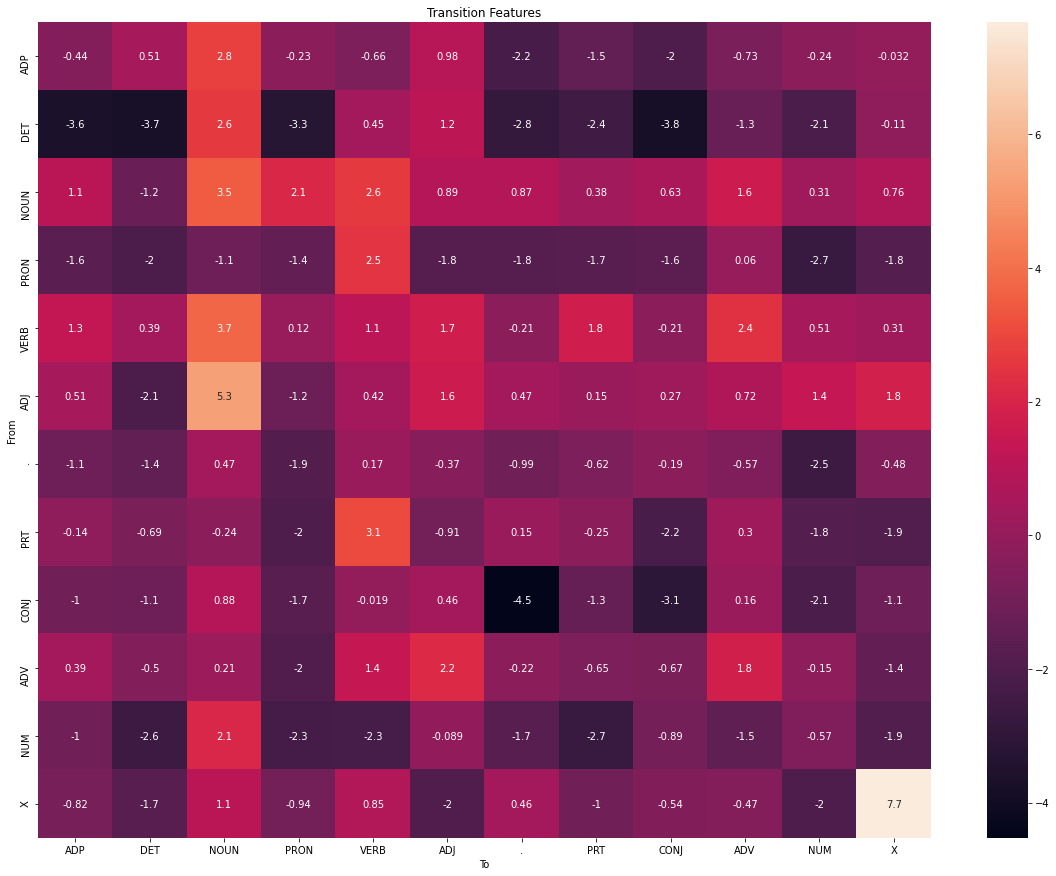

In [19]:
# Heatmap displaying Transition of Tags.
plt.figure(figsize=(20,15))
hm = sns.heatmap(data = df, annot=True)
plt.title('Transition Features')
plt.xlabel('To')
plt.ylabel('From')
plt.show()

In [20]:
# Most common transition of tags.
Counter(crf.transition_features_).most_common(20)

[(('X', 'X'), 7.669773),
 (('ADJ', 'NOUN'), 5.289938),
 (('VERB', 'NOUN'), 3.723025),
 (('NOUN', 'NOUN'), 3.48763),
 (('PRT', 'VERB'), 3.066626),
 (('ADP', 'NOUN'), 2.810561),
 (('DET', 'NOUN'), 2.645119),
 (('NOUN', 'VERB'), 2.626695),
 (('PRON', 'VERB'), 2.479242),
 (('VERB', 'ADV'), 2.423649),
 (('ADV', 'ADJ'), 2.184743),
 (('NOUN', 'PRON'), 2.112266),
 (('NUM', 'NOUN'), 2.088325),
 (('ADJ', 'X'), 1.821738),
 (('ADV', 'ADV'), 1.779627),
 (('VERB', 'PRT'), 1.75267),
 (('VERB', 'ADJ'), 1.740181),
 (('ADJ', 'ADJ'), 1.617852),
 (('NOUN', 'ADV'), 1.600076),
 (('ADV', 'VERB'), 1.396654)]

In [21]:
# Least common transition of tags.
Counter(crf.transition_features_).most_common()[-20:]

[(('PRON', 'DET'), -2.048625),
 (('ADJ', 'DET'), -2.061978),
 (('DET', 'NUM'), -2.114691),
 (('CONJ', 'NUM'), -2.134609),
 (('PRT', 'CONJ'), -2.170163),
 (('ADP', '.'), -2.199761),
 (('NUM', 'VERB'), -2.272032),
 (('NUM', 'PRON'), -2.323823),
 (('DET', 'PRT'), -2.432468),
 (('.', 'NUM'), -2.54022),
 (('NUM', 'DET'), -2.585056),
 (('PRON', 'NUM'), -2.682574),
 (('NUM', 'PRT'), -2.708385),
 (('DET', '.'), -2.81306),
 (('CONJ', 'CONJ'), -3.093159),
 (('DET', 'PRON'), -3.258694),
 (('DET', 'ADP'), -3.647355),
 (('DET', 'DET'), -3.740797),
 (('DET', 'CONJ'), -3.774316),
 (('CONJ', '.'), -4.525196)]

In [245]:
# Most common transition of features to tags.
Counter(crf.state_features_).most_common(20)

[(('suffix_4:will', 'VERB'), 9.867503),
 (('prefix_4:ally', 'NOUN'), 9.864918),
 (('suffix_4:wise', 'ADV'), 9.700545),
 (("suffix_2:'s", 'PRT'), 8.408198),
 (('suffix_4:eant', 'VERB'), 8.229702),
 (('suffix_3:ous', 'ADJ'), 8.191331),
 (('suffix_4:tood', 'VERB'), 8.161192),
 (("prev_word:didn't", 'VERB'), 7.646031),
 (('prefix_4:sure', 'ADJ'), 7.638346),
 (('prev_word:may', 'VERB'), 7.579108),
 (('suffix_2:ly', 'ADV'), 7.5156),
 (("suffix_3:'re", 'PRT'), 7.432723),
 (("suffix_2:'d", 'PRT'), 7.330718),
 (('suffix_4:pent', 'VERB'), 7.197765),
 (('prefix_4:very', 'ADV'), 7.085424),
 (("prev_word:Don't", 'VERB'), 7.070488),
 (("prev_word:wouldn't", 'VERB'), 7.063846),
 (('suffix_4:nder', 'ADP'), 7.010421),
 (('prefix_4:towa', 'ADP'), 6.990156),
 (('prev_word:could', 'VERB'), 6.80192)]

In [246]:
# Least common transition of features to tags.
Counter(crf.state_features_).most_common()[-20:]

[(('prev_word:had', 'CONJ'), -4.120795),
 (('prefix_4:fort', 'VERB'), -4.133445),
 (('next_word:Christ', 'DET'), -4.144002),
 (('suffix_4:like', 'NOUN'), -4.174666),
 (('suffix_4:less', 'VERB'), -4.202033),
 (('suffix_4:eady', 'NOUN'), -4.264952),
 (('next_word:Engine', 'ADP'), -4.330657),
 (('prefix_3:eve', 'VERB'), -4.357344),
 (('next_word:doses', 'NOUN'), -4.363991),
 (('prefix_4:leas', 'NOUN'), -4.373224),
 (('suffix_4:hort', 'NOUN'), -4.398),
 (('next_word:for', 'CONJ'), -4.531584),
 (('suffix_2:us', 'VERB'), -4.613151),
 (('prefix_4:chea', 'NOUN'), -4.646314),
 (('prefix_4:more', 'NOUN'), -4.888863),
 (('prefix_4:chem', 'ADJ'), -4.984325),
 (('next_word:of', 'PRT'), -5.075914),
 (('prefix_4:many', 'NOUN'), -5.11572),
 (('word_has_hyphen', 'VERB'), -5.556876),
 (('suffix_4:less', 'NOUN'), -6.502441)]

# Bi-Directional LSTM

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model 

In [98]:
# Function to separate each input sentence with it's respective Tags.
def Preprocess(data):
  X = []
  Y = []
  for sent in data:
    x = []
    y = []
    for s in sent:
      x.append(s[0])
      y.append(s[1])
    X.append(x)
    Y.append(y)
  return X, Y

In [99]:
X_Train, Y_Train = Preprocess(train_set)
X_Test, Y_Test = Preprocess(test_set)

In [100]:
# Creating Tokenizer for Words.
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_Train)

In [101]:
word_vocab = len(word_tokenizer.word_index) + 1
Encoded_X_train = word_tokenizer.texts_to_sequences(X_Train)
Encoded_X_test = word_tokenizer.texts_to_sequences(X_Test)

In [102]:
# Creating Tokenizer for Tags.
tag_tokenizer = Tokenizer(lower = False)
tag_tokenizer.fit_on_texts(Y_Train)

In [103]:
tag_tokenizer.word_index

{'.': 3,
 'ADJ': 6,
 'ADP': 4,
 'ADV': 7,
 'CONJ': 9,
 'DET': 5,
 'NOUN': 1,
 'NUM': 11,
 'PRON': 8,
 'PRT': 10,
 'VERB': 2,
 'X': 12}

In [104]:
Encoded_Y_train = tag_tokenizer.texts_to_sequences(Y_Train)
Encoded_Y_test = tag_tokenizer.texts_to_sequences(Y_Test)

In [ ]:
Lengths = []
for x in Encoded_X_train:
  Lengths.append(len(x))

In [105]:
max_len = 80
X_train_padded = pad_sequences(Encoded_X_train, maxlen = max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(Encoded_X_test, maxlen = max_len, padding='post', truncating='post' )
# 
y_train_padded = pad_sequences(Encoded_Y_train, maxlen = max_len, padding='post', truncating='post' )
y_test_padded = pad_sequences(Encoded_Y_test, maxlen = max_len, padding='post', truncating='post' )

In [106]:
# Using Pretrained Embedding GLove vectors.
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [107]:
# Creating a weight matrix for words in training sentences.
embedding_matrix = np.zeros((word_vocab, 100))
for word, i in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [108]:
Y_train = to_categorical(y_train_padded)
Y_test = to_categorical(y_test_padded)
Y_train.shape, Y_test.shape

((45872, 80, 13), (11468, 80, 13))

In [109]:
num_tags = Y_train.shape[2]
num_tags

13

In [110]:
tf.keras.backend.clear_session()
ip = Input(shape = (max_len, ))
emb = Embedding(word_vocab, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)(ip)
lstm = Bidirectional(LSTM(units = 64, return_sequences = True))(emb)
out = TimeDistributed(Dense(num_tags, activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed = 30)))(lstm)

In [111]:
model = Model(ip, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 100)           4516800   
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 128)           84480     
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 13)            1677      
Total params: 4,602,957
Trainable params: 86,157
Non-trainable params: 4,516,800
_________________________________________________________________


In [112]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'acc')

In [113]:
history = model.fit(X_train_padded, Y_train, batch_size = 128, epochs = 10, validation_split = 0.15)

Epoch 1/10
305/305 [==============================] - 79s 248ms/step - loss: 0.3509 - acc: 0.9264 - val_loss: 0.1097 - val_acc: 0.9692
Epoch 2/10
305/305 [==============================] - 76s 248ms/step - loss: 0.0853 - acc: 0.9761 - val_loss: 0.0690 - val_acc: 0.9805
Epoch 3/10
305/305 [==============================] - 75s 246ms/step - loss: 0.0588 - acc: 0.9831 - val_loss: 0.0519 - val_acc: 0.9849
Epoch 4/10
305/305 [==============================] - 76s 248ms/step - loss: 0.0460 - acc: 0.9866 - val_loss: 0.0426 - val_acc: 0.9876
Epoch 5/10
305/305 [==============================] - 76s 250ms/step - loss: 0.0386 - acc: 0.9887 - val_loss: 0.0368 - val_acc: 0.9892
Epoch 6/10
305/305 [==============================] - 77s 251ms/step - loss: 0.0335 - acc: 0.9901 - val_loss: 0.0330 - val_acc: 0.9902
Epoch 7/10
305/305 [==============================] - 76s 250ms/step - loss: 0.0299 - acc: 0.9911 - val_loss: 0.0299 - val_acc: 0.9911
Epoch 8/10
305/305 [==============================] - 7

In [114]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

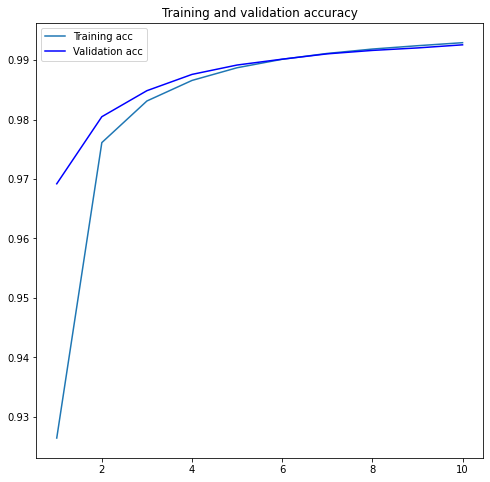

In [115]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

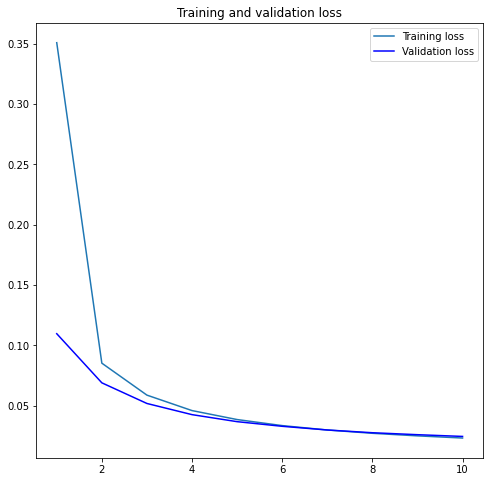

In [116]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [117]:
loss, accuracy = model.evaluate(X_test_padded, Y_test, verbose = 1)

359/359 [==============================] - 10s 28ms/step - loss: 0.5473 - acc: 0.9439


In [118]:
tag_tokenizer.sequences_to_texts(np.argmax(model.predict(X_test_padded[0:2]), axis = -1))

['PRT VERB ADJ NOUN . ADP ADJ NOUN . DET NOUN ADP NOUN . CONJ ADJ NOUN .',
 'ADP DET NOUN ADP DET NOUN ADP ADJ NOUN ADP NOUN . DET NOUN NOUN NOUN VERB NOUN ADP NOUN CONJ NOUN ADP DET NOUN CONJ NOUN .']

In [119]:
tag_tokenizer.sequences_to_texts(np.argmax(Y_test[0:2], axis=-1))

['PRT VERB ADJ NOUN . ADP ADJ NOUN . DET NOUN ADP ADJ NOUN . CONJ ADJ NOUN .',
 'ADP DET NOUN ADP DET NOUN ADP ADJ NOUN ADP NOUN . DET NOUN NOUN NOUN VERB VERB NOUN ADP NOUN CONJ NOUN ADP DET NOUN CONJ NOUN .']

In [120]:
word_tokenizer.sequences_to_texts(X_test_padded[0:2])

['there are many possibilities , including poor circulation , a variety of conditions , and functional disorders .',
 "with the co-operation of the department of physical education for men , the women's recreation association mixed tournaments in tennis and golf in the fall and spring ."]

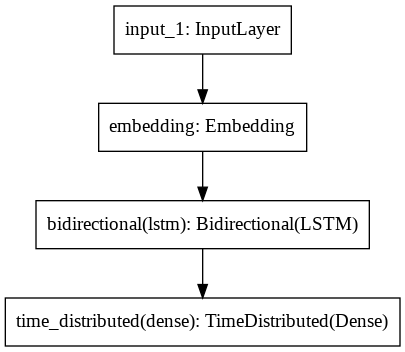

In [247]:
plot_model(model)

In [339]:
# Predicting tags for custom sentence.
te = 'Artificial Intelligence is the future.'
enc = word_tokenizer.texts_to_sequences(te.split())
enc = np.ravel(enc).tolist()
enc_pad = pad_sequences([enc], maxlen = max_len, padding='post', truncating='post')
enc_pad.shape

(1, 80)

In [340]:
# Using LSTM
pred = model.predict(enc_pad)
pred = np.argmax(pred, axis=-1)
pred

array([[6, 1, 2, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [341]:
tag_tokenizer.sequences_to_texts(pred)

['ADJ NOUN VERB DET NOUN']

In [342]:
# Using CRF
ip_fea = []
for ind in range(len(te.split())):
  ip_fea.append(features(te.split(), ind))

In [343]:
crf.predict([ip_fea])

[['ADJ', 'NOUN', 'VERB', 'DET', 'NOUN']]

Ref for CRF : https://medium.com/analytics-vidhya/pos-tagging-using-conditional-random-fields-92077e5eaa31

Ref for LSTM : https://towardsdatascience.com/pos-tagging-using-rnn-7f08a522f849